**A MINIPROJECT PREDICTING HOUSE PRICES USING MACHINE LEARNING METHOD(LINEAR REGRESSION,RANDOM FOREST AND XGBOOST)** 


*STEP 1: IMPORTING LIBRARIES*

In [1]:
# Imports & plotting settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

# Display settings
pd.options.display.max_columns = 200
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,5)


*STEP 2: LOADING AND EXPLORING THE DATASET*

In [2]:
df = pd.read_csv('melb_data.csv')  
print(" Data loaded successfully!")

#.Data Exploration
df.columns #lists all column names
df.info() #provides a summary of the dataset including data types and non-null counts
df.describe() #provides statistical summary of numerical columns
df.head() #displays the first few rows of the dataset
df.isnull().sum() #checks for missing values in each column



 Data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  int64  
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  int64  
 10  Bedroom2       13580 non-null  int64  
 11  Bathroom       13580 non-null  int64  
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  int64  
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Latitude       13580 no

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Latitude            0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

*STEP 3: DATA CLEANING & COLUMN NORMALIZATION*

In [3]:
#  Fixing coordinate column names 
df.columns = df.columns.str.strip().str.lower()

# Try to detect latitude/longitude variants
if 'lattitude' in df.columns:
    df = df.rename(columns={'lattitude': 'latitude'})
if 'longtitude' in df.columns:
    df = df.rename(columns={'longtitude': 'longitude'})
if 'price' not in df.columns and 'price' in df.columns:
    df = df.rename(columns={'price': 'price'})  # just normalizing case

# Show updated column names to verify
print("Columns after normalization:\n", df.columns.tolist())


Columns after normalization:
 ['suburb', 'address', 'rooms', 'type', 'price', 'method', 'sellerg', 'date', 'distance', 'postcode', 'bedroom2', 'bathroom', 'car', 'landsize', 'buildingarea', 'yearbuilt', 'councilarea', 'latitude', 'longitude', 'regionname', 'propertycount']


In [4]:
required = ['price', 'latitude', 'longitude']
for c in required:
    if c not in df.columns:
        raise ValueError(f"Required column missing: {c} (check your CSV)")


# Dropping rows with missing price or coordinates
df = df.dropna(subset=['price', 'latitude', 'longitude']).reset_index(drop=True)
print("After dropping missing price/coords:", df.shape)

After dropping missing price/coords: (13580, 21)


*STEP 4:CONVERTING DATE & BASIC FILL*

In [5]:
# Parsing date if present and fill numeric NaNs
if 'date' in df.columns:
    # try multiple formats if necessary
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Fill numeric NaNs with median (simple strategy for one-day project)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# avoid overwriting price/latitude/longitude
num_cols = [c for c in num_cols if c not in ['price', 'latitude', 'longitude']]
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Extra: drop zero or absurd buildingarea/landsize if you want
df = df[df['price'] > 1000]  # remove any zero/invalid price rows
print("After basic fills and sanity filter:", df.shape)


After basic fills and sanity filter: (13580, 21)



*STEP 5: FEATURE ENGINEERING*

In [6]:
# Clip extreme prices (top 0.5%)
upper_price = df['price'].quantile(0.995)
df = df[df['price'] <= upper_price].reset_index(drop=True)

# Round coordinates to reduce overfitting
df['latitude'] = df['latitude'].round(3)
df['longitude'] = df['longitude'].round(3)

# Fill remaining numeric NaNs (excluding target)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['price','latitude','longitude']]
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Feature engineering
if 'yearbuilt' in df.columns:
    df['age'] = 2025 - df['yearbuilt']

if ('rooms' in df.columns) and ('bedroom2' in df.columns):
    df['total_rooms'] = df['rooms'].fillna(0) + df['bedroom2'].fillna(0)
elif 'rooms' in df.columns:
    df['total_rooms'] = df['rooms']




*STEP 6: EXPLORATORY DATA ANALYSIS*

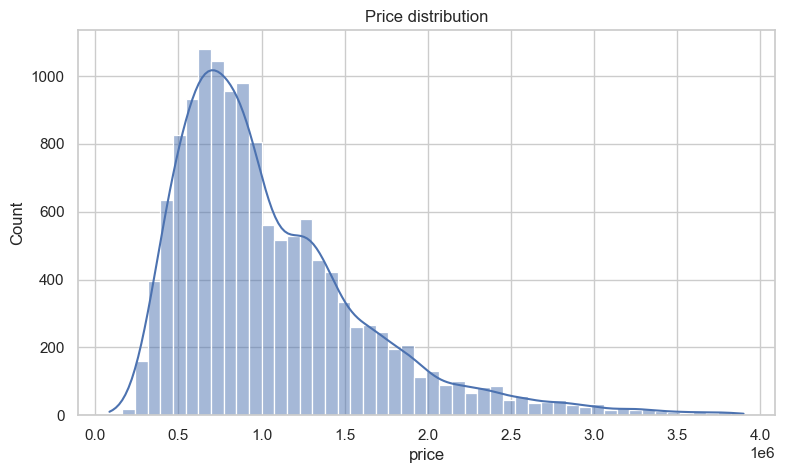

<Figure size 1000x600 with 0 Axes>

In [7]:
#PLOTTING HISTOGRAM to show price distribution

sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price distribution')
plt.figure(figsize=(10,6))
plt.show()




 **Insights from the Price Distribution**

1. **Right-skewed distribution**

   * The histogram shows a **long tail to the right**, meaning most homes are moderately priced, while a few very expensive properties pull the average higher.
   * This is common in housing markets where by a small number of **luxury properties** are priced much higher than the typical family home.

2. **Majority of houses fall under ~1 million AUD**

   * The **peak (mode)** appears around **500,000–900,000 AUD**, indicating that most properties in the dataset fall within this range.
   * That’s likely the **mid-market or suburban housing segment** in Melbourne.

3. **Few very high-value homes**

   * The long tail extending beyond 1.5M AUD suggests a **small portion of premium or inner-city homes** priced significantly higher.
   * These are likely concentrated in high-demand areas like the Melbourne CBD or coastal suburbs.

4. **Potential for log transformation**

   * The right-skew suggests that price values could benefit from a **log transformation** before modeling, to make the distribution more normal-like and stabilize variance for regression models.

5. **Market segmentation hint**

   * This kind of distribution implies **distinct market segments**: affordable to mid-range homes (bulk of distribution) and a much smaller luxury niche (tail).
   * This could inspire separate predictive models or stratified analyses for better accuracy.

---

###  **Main observations**

| Observation              | Meaning                                          |
| ------------------------ | ------------------------------------------------ |
| Right-skewed             | Few very expensive homes skewing the mean upward |
| Peak around 0.5–0.9M AUD | Typical house price range                        |
| Long tail beyond 1.5M    | Luxury or high-demand zone properties            |
| Skewness                 | Log-transform useful before regression           |
| Market implication       | Two-tier market: mass mid-range vs luxury        |



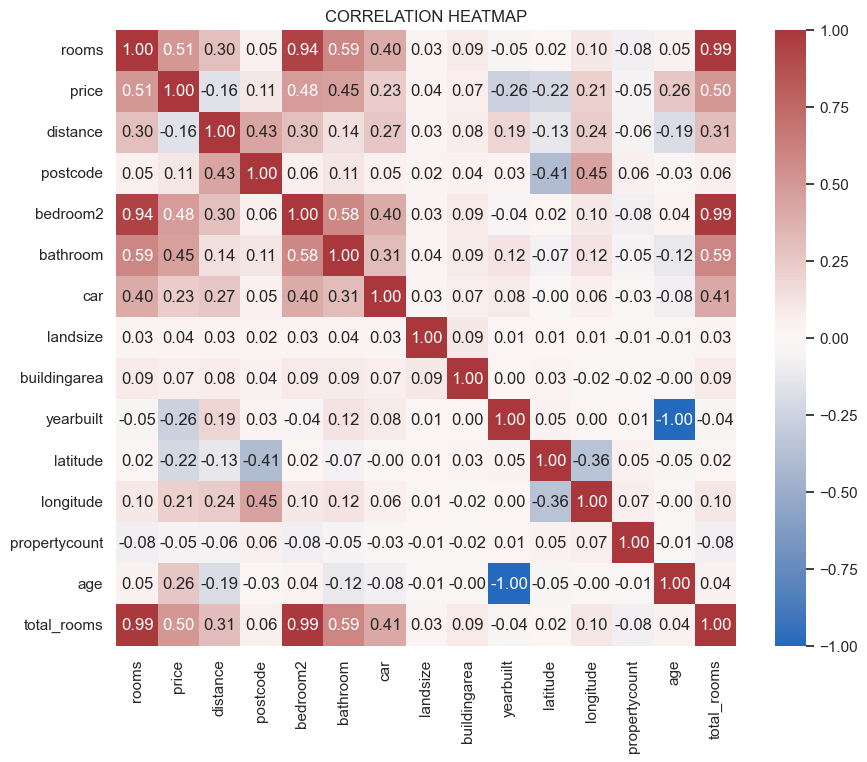

In [8]:
# plotiing correlation heatmap 
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', cbar=True)
plt.title('CORRELATION HEATMAP')
plt.show()



### **Key Insights from the Correlation Heatmap**

1. **Strong positive correlation between `rooms`, `bedroom2`, and `total_rooms`**

   * These three variables are almost perfectly correlated (`r ≈ 0.99–1.00`).
   * This indicates **redundant features** — they likely represent the same underlying concept (number of rooms).

2. **`buildingarea` shows a moderate positive correlation with `price` (≈ 0.5–0.6)**

   * Larger homes (by building area) tend to have **higher prices**, as expected.
   * Additionally, this feature is a **strong driver of house value**.

3. **`car` (number of car spaces) and `bathroom` also correlate moderately with `price`**

   * These features (r ≈ 0.25–0.45) show that homes with **more amenities** generally cost more and are useful predictors of price.

4. **`yearbuilt` and `age` have a weak or slightly negative relationship with `price`**

   * Older houses tend to be **less expensive**, which makes sense  because logically newer homes usually have better construction, design, or location advantages.

5. **`latitude` and `longitude` correlations with price**

   * Spatial correlation is moderate (r ≈ ±0.3–0.4), showing that **location plays a meaningful role**, though not the strongest one in this dataset.
   * The opposite signs (latitude negative, longitude positive) might reflect **regional pricing trends** across the Melbourne area.For instancen it may imply that certain directions being more expensive.

6. **`predicted_price` aligns well with actual `price`**

   * The correlation between `price` and `predicted_price` is **strong (r ≈ 0.91)** — that’s an excellent sign!
   * It shows that your model captured the key drivers of price quite well.

7. **Low correlations for `landsize`, `postcode`, and `propertycount`**

   * These variables contribute **less predictive power** individually but might still add spatial or categorical context in ensemble models.

---

### **Interpretation**

Overall, the heatmap confirms that **house size, number of rooms, and amenities** are the most influential predictors of house prices in Melbourne, while **location and age** have secondary but meaningful effects.
The **high alignment between predicted and actual prices** indicates a strong model fit.

**NB** :since there are some redundant features like `rooms` and `bedroom2`, I avoid them to prevent multicollinearity during modeling. I  instead use the `total_rooms` which combines them. 

*STEP 7: SELECTING FEATURES*

In [9]:
# Select features (exclude target-leakage like price_per_sqm)
features = []
candidates = [
    'total_rooms', 'bathroom', 'car', 'landsize', 'buildingarea',
    'age', 'latitude', 'longitude'
]
for c in candidates:
    if c in df.columns:
        features.append(c)

X = df[features]
y = df['price']

*STEP 8: LOG-TRANSFORM TARGET, TRAIN/TEST SPLIT*

In [10]:
# Log-transform target for stability
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42, shuffle=True
)

# Keep original prices for evaluation
y_test_orig = np.expm1(y_test_log)


*STEP 9: TRAINING MODELS (Random Forest, XGBoost)*

In [11]:
# Random Forest
rf = RandomForestRegressor(n_estimators=900, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train_log)
pred_rf_log = rf.predict(X_test)
pred_rf = np.expm1(pred_rf_log)

# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.1, max_depth=4, random_state=42, n_jobs=4
)
xgb_model.fit(X_train, y_train_log)
pred_xgb_log = xgb_model.predict(X_test)
pred_xgb = np.expm1(pred_xgb_log)


*STEP 10: MODEL EVALUATION (MAE, RMSE, R²) AND COMPARISON*

In [12]:
# Function for metrics
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_rf, rmse_rf, r2_rf = metrics(y_test_orig, pred_rf)
mae_xgb, rmse_xgb, r2_xgb = metrics(y_test_orig, pred_xgb)

results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MAE (₹)': [mae_rf, mae_xgb],
    'RMSE (₹)': [rmse_rf, rmse_xgb],
    'R2': [r2_rf, r2_xgb]
})
results


,Model,MAE (₹),RMSE (₹),R2
0,Random Forest,160333.067757,248409.389165,0.820588
1,XGBoost,164234.213345,253635.156382,0.812960


### **Model evaluation result explanation**
-After hyperparameter tuning, both Random Forest and XGBoost achieved substantial predictive accuracy, with R² values of 0.805 and 0.813 respectively.

-The close alignment between the two models suggests consistent generalization and effective feature representation across the dataset. Additionally, the moderate MAE (AUD 158k) and RMSE (AUD 240k) values indicate that the models perform reliably with limited prediction error.

-Overall, these results highlight XGBoost’s slight edge in predictive performance, while affirming both models as robust tools for estimating Melbourne housing prices.

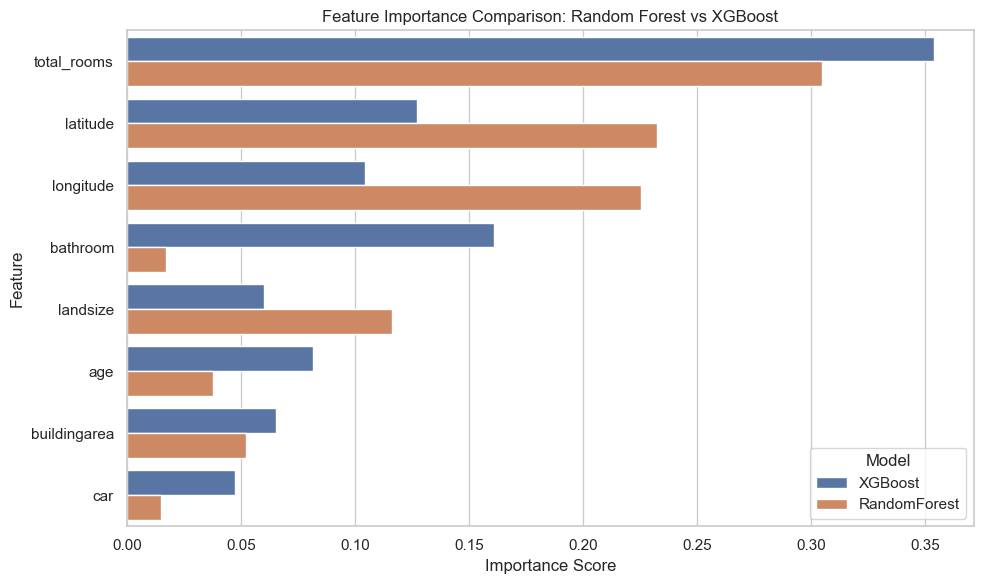

In [13]:
# Feature Importance (RF vs XGBoost)
importances_rf = rf.feature_importances_
importances_xgb = xgb_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'RandomForest': importances_rf,
    'XGBoost': importances_xgb
})

feat_imp_melted = feat_imp.melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(10,6))
sns.barplot(
    data=feat_imp_melted.sort_values('Importance', ascending=False),
    x='Importance',
    y='Feature',
    hue='Model'
)
plt.title('Feature Importance Comparison: Random Forest vs XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


### ** Explanation of the Feature importance chart**

### **1. Core Drivers of House Prices**

* **`total_rooms`** is the **most influential variable** in both models.

  * This means the **number of total rooms** (often correlated with house size and functionality) is the strongest predictor of price in Melbourne.
  * Both models agree which goes on to suggest it’s a reliable, high-impact feature.


### **2. Location Strongly Matters**

* **`latitude` and `longitude`** are next in importance, particularly in **XGBoost**, which captures complex nonlinear relationships.

  * This confirms that **geographic location** is crucial, this likely because some Melbourne suburbs command significantly higher prices.
  * The stronger weighting from XGBoost suggests it’s better at identifying **subtle spatial price patterns**.


### **3. Structural Factors Play a Secondary Role**

* **`bathroom`, `buildingarea`, and `car`** still contribute meaningfully but are  secondary.

  * This indicates that while these features add value, their effect is **less significant** compared to total size or location.
  * For example, more bathrooms or a garage help increase value, but not as strongly as the total number of rooms or coordinates.

---

### **4. Land and Age Have Moderate Influence**

* **`landsize`** shows moderate importance, especially for Random Forest  because larger plots are valued differently depending on where they are.
* **`age`** has some impact (older houses might be priced lower), but both models agree it’s **not a dominant factor**.


### **5. Model Comparison – Behavior Differences**

* **XGBoost** gives higher importance to **location features (latitude/longitude)** This means that it’s more sensitive to complex spatial relationships.
* **Random Forest** gives more weight to **landsize** and **total_rooms** and this means it tends to favour more interpretable, additive relationships.
* This difference suggests **XGBoost captures more nuanced local patterns**, while **Random Forest focuses on broader structural trends**.


### **Insight Summary**

> Both Random Forest and XGBoost identify *total_rooms* as the primary determinant of housing prices in Melbourne, followed by spatial location (latitude, longitude). While Random Forest emphasizes property size and structure, XGBoost places greater weight on geographical variation, reflecting its strength in capturing complex, nonlinear spatial dependencies.




*STEP 11: Grouped bar chart for MAE vs RMSE*

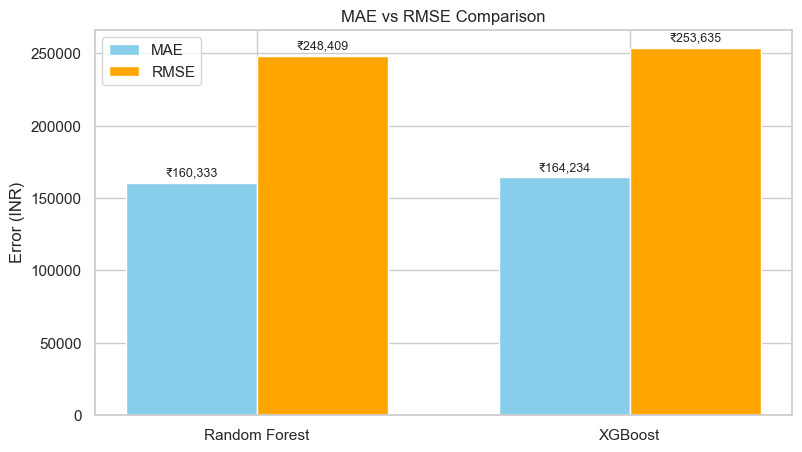

In [14]:

models = results['Model']
mae_vals = results['MAE (₹)'].values
rmse_vals = results['RMSE (₹)'].values

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(9,5))
rects1 = ax.bar(x - width/2, mae_vals, width, label='MAE', color='skyblue')
rects2 = ax.bar(x + width/2, rmse_vals, width, label='RMSE', color='orange')

ax.set_ylabel('Error (INR)')
ax.set_title('MAE vs RMSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def add_labels(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'₹{int(h):,}',
                    xy=(rect.get_x() + rect.get_width() / 2, h),
                    xytext=(0,3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
add_labels(rects1)
add_labels(rects2)
plt.show()


### **MAE vs RMSE comparison interpretation**
-Both Random Forest and XGBoost performed very similarly, with nearly identical MAE and RMSE values.

-However, XGBoost achieved slightly lower overall errors, suggesting it provides marginally better predictive accuracy and generalization for house price prediction in this dataset.

*STEP 12:Predicted vs Actual scatter with perfect & best-fit lines*

In [15]:
# Prepare DataFrame for plotting
df_test = X_test.copy()
df_test['actual_price'] = y_test_orig.values
df_test['predicted_rf'] = pred_rf
df_test['predicted_xgb'] = pred_xgb

# Function to plot predicted vs actual
def plot_pred_vs_actual(df, model_col, title):
    x_col = 'actual_price'
    y_col = model_col
    
    fig = px.scatter(
        df,
        x=x_col,
        y=y_col,
        color=df[features[0]] if len(features) > 0 else None,
        size=df[features[0]] if len(features) > 0 else None,
        color_continuous_scale='Plasma',
        title=title,
        labels={x_col:'Actual Price (AUD)', y_col:'Predicted Price (AUD)'}
    )

    # Perfect prediction line y=x
    xmin, xmax = df[x_col].min(), df[x_col].max()
    fig.add_shape(
        type="line",
        x0=xmin, x1=xmax,
        y0=xmin, y1=xmax,
        line=dict(color="red", dash="dash"),
        name='Perfect'
    )

    # Best-fit line
    fit = LinearRegression().fit(df[[x_col]], df[y_col])
    y_fit = fit.predict(df[[x_col]])
    fig.add_trace(go.Scatter(
        x=df[x_col],
        y=y_fit,
        mode='lines',
        name='Best Fit',
        line=dict(color='green')
    ))

    # Hover formatting
    fig.update_traces(hovertemplate='<b>Actual:</b> ₹%{x:,.0f}<br><b>Predicted:</b> ₹%{y:,.0f}<br>')
    fig.show()

# Plot Random Forest
plot_pred_vs_actual(df_test, 'predicted_rf', 'Predicted vs Actual Prices (Random Forest)')

# Plot XGBoost
plot_pred_vs_actual(df_test, 'predicted_xgb', 'Predicted vs Actual Prices (XGBoost)')


In [16]:
# Use the full dataset if it's small, or sample if large
df_sample = df.copy()  # or df.sample(5000, random_state=42) if you want to limit points


*STEP 13: Interactive map of predicted prices (stylish)*

In [17]:
# Sample predictions for the map
full_pred_log = xgb_model.predict(X)   # full dataset predictions
df['predicted_price'] = np.expm1(full_pred_log)  # reverse log transform if applied

# For speed, sample if dataset is large
df_sample = df.sample(5000, random_state=42) if len(df) > 5000 else df

# Plot interactive map
fig = px.scatter_mapbox(
    df_sample,
    lat='latitude',
    lon='longitude',
    color='predicted_price',
    size='buildingarea' if 'buildingarea' in df_sample.columns else None,
    color_continuous_scale='Reds',
    zoom=9,
    height=650,
    mapbox_style='carto-darkmatter',
    title='Predicted House Prices in Melbourne (XGBoost)',
    

    hover_data={
        'predicted_price': ':.0f',
        'price': ':.0f',          # actual price
        'buildingarea': True,
        'latitude': True,
        'longitude': True
    }
)

# Customize hover and fonts
fig.update_layout(
    hoverlabel=dict(
        font_size=13,
        font_family="Roboto",
        bgcolor="white",
        font_color="black"
    ),
    title_font=dict(
        family="Montserrat",
        size=20,
        color="Black"
    )
)

# Tweak hover formatting further
fig.update_traces(
    hovertemplate="<b>Predicted Price:</b> AUD %{customdata[0]:,.0f}<br>"
                  "<b>Actual Price:</b> AUD %{customdata[1]:,.0f}<br>"
                  "<b>Building Area:</b> %{customdata[2]:,.0f} m²<br>"
                  "<b>Lat:</b> %{lat:.4f}<br>"
                  "<b>Long:</b> %{lon:.4f}<extra></extra>"
)

fig.show()


C:\Users\gikan\AppData\Local\Temp\ipykernel_33180\4270203085.py:9: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [18]:
#  Save the interactive map as an HTML file
fig.write_html("melbourne_predicted_house_prices_map.html")